# Facial Keypoint Detection
  
This project will be all about defining and training a convolutional neural network to perform facial keypoint detection, and using computer vision techniques to transform images of faces. Let's take a look at some examples of images and corresponding facial keypoints.

<img src='images/key_pts_example.png' width=50% height=50%/>

Facial keypoints (also called facial landmarks) are the small magenta dots shown on each of the faces in the image above. In each training and test image, there is a single face and **68 keypoints, with coordinates (x, y), for that face**.  These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc. These keypoints are relevant for a variety of tasks, such as face filters, emotion recognition, pose recognition, and so on. Here they are, numbered, and we can see that specific ranges of points match different portions of the face.

<img src='images/landmarks_numbered.jpg' width=30% height=30%/>

---

## 1.0. Load and Visualize Data

### 1.1. Training and Testing Data

This facial keypoints dataset consists of 5770 color images. All of these images are separated into either a training or a test set of data.

* 3462 of these images are training images, for us to use as we create a model to predict keypoints.
* 2308 are test images, which will be used to test the accuracy of the model.

The information about the images and keypoints in this dataset are summarized in CSV files, which we can read in using `pandas`. Let's read the training CSV and get the annotations in an (N, 2) array where N is the number of keypoints and 2 is the dimension of the keypoint coordinates (x, y).

In [29]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [30]:
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv')

n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [31]:
# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


### 1.2. Visualize Some Images

Below, is a function `show_keypoints` that takes in an image and keypoints and displays them.  As we look at this data, **note that these images are not all of the same size**, and neither are the faces! To eventually train a neural network on these images, we'll need to standardize their shape.

In [32]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

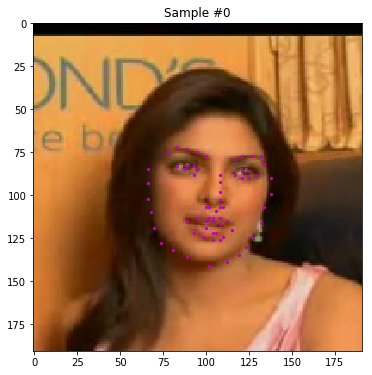

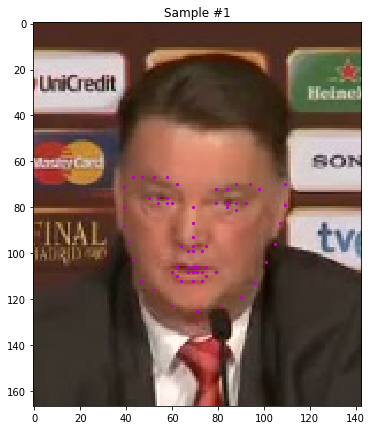

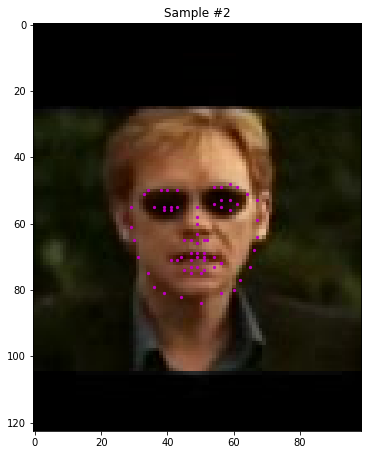

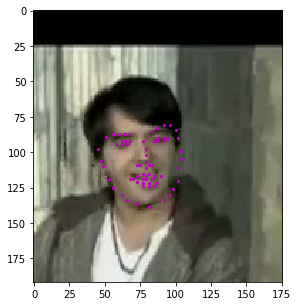

In [33]:
# Display a few different types of images by changing the index n

# select an image by index in our data frame
n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('data/training/', image_name)), key_pts)
plt.show()

---
## 2.0. Pre-process Images

### 2.1. Create Dataset

To prepare our data for training, we'll be using PyTorch's Dataset class. Much of this this code is a modified version of what can be found in the [PyTorch data loading tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

``torch.utils.data.Dataset`` is an abstract class representing a
dataset. This class will allow us to load batches of image/keypoint data, and uniformly apply transformations to our data, such as rescaling and normalizing images for training a neural network.

In [34]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

Now that we've defined this class, let's instantiate the dataset.

In [35]:
# Construct the dataset
face_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                      root_dir='data/training/')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


The images above are not of the same size, and neural networks expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, we will need to write some pre-processing code.
Let's create four transforms:

-  ``Normalize``: to convert a color image to grayscale values with a range of [0,1] and normalize the keypoints to be in a range of about [-1, 1]
-  ``Rescale``: to rescale an image to a desired size.
-  ``RandomCrop``: to crop an image randomly.
-  ``ToTensor``: to convert numpy images to torch images.

In [36]:
import torch
from torchvision import transforms, utils

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

### 2.2. Create Transformed Dataset
Now, we create the transformed dataset.

In [37]:
# define the data tranform
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create training dataset
training_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                          root_dir='data/training/',
                                          transform=data_transform)

# create test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

### 2.3. Data Iteration and Batching
Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model.

In [38]:
batch_size = 20

# load training data in batches
train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

# load test data in batches
test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size,
                         shuffle=True, 
                         num_workers=4)

---
## 3.0. Define the Convolutional Neural Network
Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

### 3.1. Network Architecture
We use [this paper](https://arxiv.org/pdf/1710.00977.pdf) to help in determining the structure of our network.

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (dropout1): Dropout(p=0.1)
  (dropout2): Dropout(p=0.2)
  (dropout3): Dropout(p=0.3)
  (dropout4): Dropout(p=0.4)
  (dropout5): Dropout(p=0.5)
  (dropout6): Dropout(p=0.6)
)


### 3.2. Training
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, we need to choose a loss function that is suited for regression, which directly compares a predicted value and target value.

We'll define how the model will train by deciding on the loss function and optimizer.

In [40]:
## Define the loss and optimization function
import torch.optim as optim

lr = 0.001
beta1=0.9
beta2=0.999

## Define loss function
criterion = nn.MSELoss()

## Define optimizer
optimizer = optim.Adam(net.parameters(), lr, [beta1, beta2])

In [41]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes we already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')

In [42]:
# train the network
n_epochs = 30

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.0033598141223192216
Epoch: 1, Batch: 20, Avg. Loss: 0.002177169233560562
Epoch: 1, Batch: 30, Avg. Loss: 0.0018478364795446395
Epoch: 1, Batch: 40, Avg. Loss: 0.001992840871214867
Epoch: 1, Batch: 50, Avg. Loss: 0.001965122826397419
Epoch: 1, Batch: 60, Avg. Loss: 0.00212377655506134
Epoch: 1, Batch: 70, Avg. Loss: 0.0017470481246709823
Epoch: 1, Batch: 80, Avg. Loss: 0.00212932451069355
Epoch: 1, Batch: 90, Avg. Loss: 0.00196855129301548
Epoch: 1, Batch: 100, Avg. Loss: 0.0020859735906124115
Epoch: 1, Batch: 110, Avg. Loss: 0.00242848140001297
Epoch: 1, Batch: 120, Avg. Loss: 0.001974940285086632
Epoch: 1, Batch: 130, Avg. Loss: 0.0022671366930007934
Epoch: 1, Batch: 140, Avg. Loss: 0.002064752981066704
Epoch: 1, Batch: 150, Avg. Loss: 0.0020455350279808045
Epoch: 1, Batch: 160, Avg. Loss: 0.0016055959016084672
Epoch: 1, Batch: 170, Avg. Loss: 0.002013646714389324
Epoch: 2, Batch: 10, Avg. Loss: 0.0018362413495779037
Epoch: 2, Batch: 20, Avg. Loss: 0.

Epoch: 9, Batch: 170, Avg. Loss: 0.0008164301067590714
Epoch: 10, Batch: 10, Avg. Loss: 0.0010903766117990018
Epoch: 10, Batch: 20, Avg. Loss: 0.0009166603311896324
Epoch: 10, Batch: 30, Avg. Loss: 0.0006936688981950283
Epoch: 10, Batch: 40, Avg. Loss: 0.0006777058765292167
Epoch: 10, Batch: 50, Avg. Loss: 0.0007960427142679692
Epoch: 10, Batch: 60, Avg. Loss: 0.0006585121601819992
Epoch: 10, Batch: 70, Avg. Loss: 0.0006246487610042095
Epoch: 10, Batch: 80, Avg. Loss: 0.0007059054337441921
Epoch: 10, Batch: 90, Avg. Loss: 0.0006228950843214988
Epoch: 10, Batch: 100, Avg. Loss: 0.000647709634155035
Epoch: 10, Batch: 110, Avg. Loss: 0.0011638020575046538
Epoch: 10, Batch: 120, Avg. Loss: 0.0007765721306204796
Epoch: 10, Batch: 130, Avg. Loss: 0.0006004691198468208
Epoch: 10, Batch: 140, Avg. Loss: 0.0008043916001915932
Epoch: 10, Batch: 150, Avg. Loss: 0.0014785847179591657
Epoch: 10, Batch: 160, Avg. Loss: 0.0008117608800530434
Epoch: 10, Batch: 170, Avg. Loss: 0.0006693718098104
Epoch:

Epoch: 18, Batch: 130, Avg. Loss: 0.000556401077657938
Epoch: 18, Batch: 140, Avg. Loss: 0.0007891566157341004
Epoch: 18, Batch: 150, Avg. Loss: 0.0006758546493947506
Epoch: 18, Batch: 160, Avg. Loss: 0.0006099150143563747
Epoch: 18, Batch: 170, Avg. Loss: 0.000784969799220562
Epoch: 19, Batch: 10, Avg. Loss: 0.0004887018129229546
Epoch: 19, Batch: 20, Avg. Loss: 0.0005152335911989212
Epoch: 19, Batch: 30, Avg. Loss: 0.0005439976472407579
Epoch: 19, Batch: 40, Avg. Loss: 0.0006043750643730163
Epoch: 19, Batch: 50, Avg. Loss: 0.0006278314776718616
Epoch: 19, Batch: 60, Avg. Loss: 0.0006858533918857574
Epoch: 19, Batch: 70, Avg. Loss: 0.0005160727836191654
Epoch: 19, Batch: 80, Avg. Loss: 0.0007103429846465587
Epoch: 19, Batch: 90, Avg. Loss: 0.0007948235794901847
Epoch: 19, Batch: 100, Avg. Loss: 0.0009107727147638798
Epoch: 19, Batch: 110, Avg. Loss: 0.0006843473985791206
Epoch: 19, Batch: 120, Avg. Loss: 0.0004982786290347577
Epoch: 19, Batch: 130, Avg. Loss: 0.0007822354212403298
Epo

Epoch: 27, Batch: 80, Avg. Loss: 0.0005061072241514921
Epoch: 27, Batch: 90, Avg. Loss: 0.000622715212404728
Epoch: 27, Batch: 100, Avg. Loss: 0.0005931650623679162
Epoch: 27, Batch: 110, Avg. Loss: 0.0004651473760604858
Epoch: 27, Batch: 120, Avg. Loss: 0.0007629710137844086
Epoch: 27, Batch: 130, Avg. Loss: 0.000449218712747097
Epoch: 27, Batch: 140, Avg. Loss: 0.00044486263766884803
Epoch: 27, Batch: 150, Avg. Loss: 0.0010279365703463553
Epoch: 27, Batch: 160, Avg. Loss: 0.00043047141656279563
Epoch: 27, Batch: 170, Avg. Loss: 0.000497956708073616
Epoch: 28, Batch: 10, Avg. Loss: 0.0004722880683839321
Epoch: 28, Batch: 20, Avg. Loss: 0.000624576086178422
Epoch: 28, Batch: 30, Avg. Loss: 0.0005534270331263542
Epoch: 28, Batch: 40, Avg. Loss: 0.001341922525316477
Epoch: 28, Batch: 50, Avg. Loss: 0.0008167591542005539
Epoch: 28, Batch: 60, Avg. Loss: 0.0005179685801267624
Epoch: 28, Batch: 70, Avg. Loss: 0.001013840653002262
Epoch: 28, Batch: 80, Avg. Loss: 0.000953329186886549
Epoch: 

### 3.3. Testing
To test the model on a test sample of data, we have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [43]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts        

In [44]:
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([20, 1, 224, 224])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


We'll see how our model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, we'll run our trained model on these images to see what kind of keypoints are produced. We should be able to see if our model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it. We've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [46]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

Next, we'll see a helper function `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of our CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that we applied these transformations when we loaded our test data.

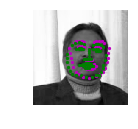

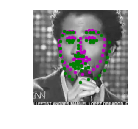

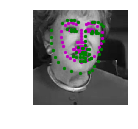

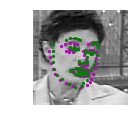

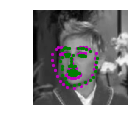

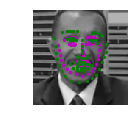

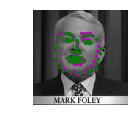

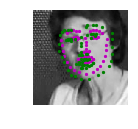

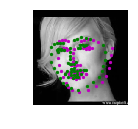

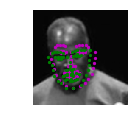

In [47]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
visualize_output(test_images, test_outputs, gt_pts)

We save our model so you can load it and use it later.

In [48]:
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save our model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

---
## 4.0. Facial Key Detection, Complete Pipeline
After we've trained a neural network to detect facial keypoints, we can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, we'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` we created and applied in the previous sections, whose job was to rescale, normalize, and turn any iimage into a Tensor to be accepted as input to our CNN.
3. Use our trained model to detect facial keypoints on the image.

### 4.1. Select an Image

We use the following image to perform facial keypoint detection.

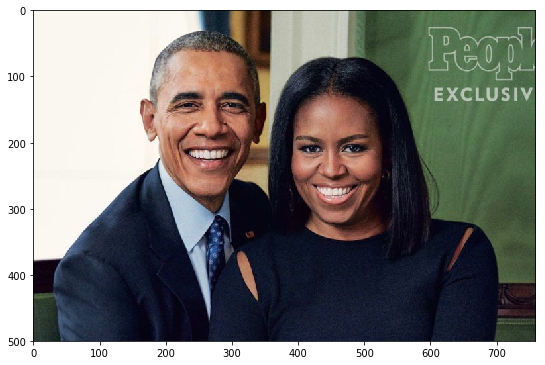

In [51]:
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

plt.show()

### 4.2. Detect All Faces in the Image
Next, we'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). 

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>

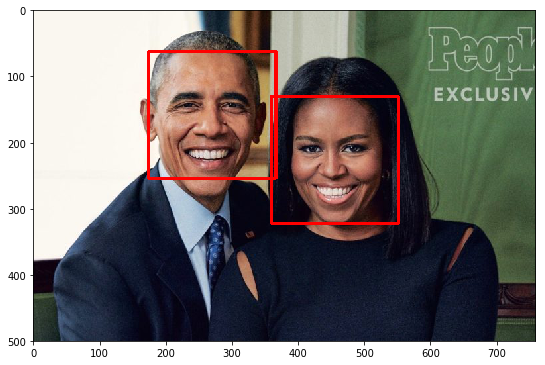

In [54]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 2, 3)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # we may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

plt.show()

### 4.3. Load the Trained Model
Once we have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into our CNN facial keypoint detector.

First, load your best model by its filename.

In [55]:
import torch
from models import Net

net = Net()

## load the best saved model parameters
net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))

## print out your net and prepare it for testing
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (dropout1): Dropout(p=0.1)
  (dropout2): Dropout(p=0.2)
  (dropout3): Dropout(p=0.3)
  (dropout4): Dropout(p=0.4)
  (dropout5): Dropout(p=0.5)
  (dropout6): Dropout(p=0.6)
)

### 4.4. Keypoint Detection

We'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

<img src='images/michelle_detected.png' width=30% height=30%/>

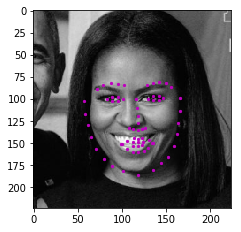

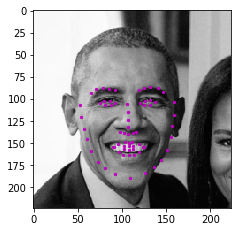

In [58]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image 
    wpad = int(w*0.3)
    hpad = int(h*0.3)
    
    roi = image_copy[y-hpad:y+h+hpad, x-wpad:x+w+wpad]
    
    ## TODO: Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi/255.0
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (224, 224)).reshape(224,224,1)
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi= torch.from_numpy(roi.transpose(2, 0, 1))
    
    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    
    
    ## perform a forward pass to get the predicted facial keypoints
    net.eval()
    
    roi = roi.type(torch.FloatTensor)
    roi = roi.unsqueeze(0)
    output_pts = net.forward(roi)
    output_pts = output_pts.view(68, 2)   
    output_pts = output_pts.data.numpy()
    
    # undo normalization of keypoints  
    output_pts = output_pts*50+100
    
    ## TODO: Display each detected face and the corresponding keypoints  
    # un-transform the predicted key_pts data

    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 2)
    
    show_all_keypoints(np.squeeze(roi), output_pts)
    
    plt.show()
        